In [1]:
import pandas as pd 
import sqlite3
import sys
sys.path.append('../util/')
import util_newssniffer_parsing as unp
from IPython.display import display, HTML
import os

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
path_to_data = '../data/diffengine-diffs/spark-output'
con = sqlite3.connect(os.path.join(path_to_data, 'wp-matched-sentences.db'))

In [3]:
path_to_data = '../data/diffengine-diffs/db'

In [5]:
pd.read_sql('''SELECT 
                    name
                FROM 
                    sqlite_master 
                WHERE 
                    type ='table' AND 
                    name NOT LIKE 'sqlite_%';
''', con=con)

,name
0,matched_sentences
1,split_sentences


In [35]:
pd.read_sql('''SELECT COUNT(*) FROM MATCHED_SENTENCES;
''', con = con)

,COUNT(*)
0,2520474


In [41]:
pd.read_sql('''SELECT * FROM SPLIT_SENTENCES LIMIT 5;''', con = con)

,entry_id,version,sent_idx,sentence
0,1094962,0,0,BEIRUT — The Latest developments on the war in...
1,1094962,0,1,(all times local): 11:45 a.m.
2,1094962,0,2,The Russian defense ministry says its airstrik...
3,1094962,0,3,The defense ministry in a statement on Thursda...
4,1094962,0,4,A Syrian government offensive around the city ...


In [6]:
pd.read_sql('''
    SELECT * FROM matched_sentences 
    ORDER BY entry_id, version_x, version_y, sent_idx_x, sent_idx_y
    limit 100
''', con=con)

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,728192,0,1,0.0,0.0,0.194212,0.194212
1,728192,0,1,1.0,1.0,0.348694,0.345599
2,728192,0,1,2.0,2.0,0.402505,0.402505
3,728192,0,1,3.0,3.0,0.000000,0.000000
4,728192,0,1,4.0,4.0,0.211175,0.211175
...,...,...,...,...,...,...,...
95,728194,0,1,1.0,NaN,NaN,NaN
96,728194,0,1,2.0,NaN,NaN,NaN
97,728194,0,1,3.0,NaN,NaN,NaN
98,728194,0,1,4.0,NaN,NaN,NaN


In [7]:
pd.read_sql('''
    SELECT * FROM split_sentences
    ORDER BY entry_id, version, sent_idx
    limit 5
''', con=con)

,entry_id,version,sent_idx,sentence
0,728192,0,0,"KIEV, Ukraine — Tens of thousands of protester..."
1,728192,0,1,Sunday’s rally was the first since President V...
2,728192,0,2,His doing so has re-stoked anger among the opp...
3,728192,0,3,"Looking for a fight, several hundred demonstra..."
4,728192,0,4,They shot off fireworks and threw flares and s...


In [24]:
pd.read_sql('''
    SELECT * FROM split_sentences
    WHERE version != 0
    ORDER BY entry_id, version, sent_idx
    limit 5
''', con=con)

,entry_id,version,sent_idx,sentence
0,728192,1,0,"KIEV, Ukraine — Tens of thousands of protester..."
1,728192,1,1,Sunday’s rally was the first since President V...
2,728192,1,2,His action re-stoked anger among the opposition.
3,728192,1,3,"Looking for a fight, several hundred demonstra..."
4,728192,1,4,They ignited fireworks and threw flares and st...


# Basic Data Analysis

In [4]:
import glob

In [142]:
def get_sent_operations(con):
    output = {}
    new_sent_slot = pd.read_sql('''
        SELECT sent_idx_y, sent_idx_x IS NULL AS addition
        FROM matched_sentences
        WHERE sent_idx_y < 100
    ''', con=con)
    output['new_sent_slot'] = new_sent_slot
    
    #### 
    del_sent_slot = pd.read_sql('''
        SELECT sent_idx_x, sent_idx_y IS NULL AS deletion
        FROM matched_sentences
        WHERE sent_idx_x < 100
    ''', con=con)
    output['del_sent_slot'] = del_sent_slot
    
    ####
    edit_slot = pd.read_sql('''
        SELECT sent_idx_x, (
                        ((sent_idx_x IS NOT NULL) AND (sent_idx_y IS NOT NULL)) AND
                        ((avg_sentence_distance_x > 0) OR (avg_sentence_distance_y > 0))
                    ) as edit
        FROM matched_sentences
        WHERE sent_idx_x < 100
    ''', con=con)
    output['edit_sent_slot'] = edit_slot


    ### 
    if False:
        perc_new_sents = pd.read_sql('''
            SELECT entry_id, version_x, version_y, AVG(addition) as perc_new_sents FROM (
            SELECT *, sent_idx_x IS NULL AS addition
            FROM matched_sentences
            )
            GROUP BY entry_id, version_x, version_y
            ORDER BY entry_id, version_x, version_y
        ''', con=con)
        output['perc_new_slot'] = perc_new_sents

        num_sents = pd.read_sql('''
            SELECT entry_id, version, count(1) as num_sents
            FROM split_sentences
            group by entry_id, version
        ''', con=con)
        output['new_sents'] = new_sents

    ###
    return output

def get_perc(con):
    perc_sents = pd.read_sql('''
        SELECT 
        entry_id,
        version_x,
        version_y,
        AVG(addition) as perc_new_sents,
        AVG(deletion) as perc_old_sents,
        AVG(edit) as perc_edited_sents
        FROM (
            SELECT 
                *, 
                sent_idx_x IS NULL AS addition, 
                sent_idx_y IS NULL AS deletion,
                (
                    ((sent_idx_x IS NOT NULL) AND (sent_idx_y IS NOT NULL)) AND
                    ((avg_sentence_distance_x > 0) OR (avg_sentence_distance_y > 0))
                ) as edit
            FROM matched_sentences
        )
        GROUP BY entry_id, version_x, version_y
    ''', con=con)
    return perc_sents

In [8]:
import glob
import sqlite3
import pandas as pd 

In [164]:
to_run = glob.glob('../data/diffengine-diffs/spark-output/*')

In [166]:
to_run

['../data/diffengine-diffs/spark-output/independent-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/nyt-matched-sentences.db',
 '../data/diffengine-diffs/spark-output/reuters-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/ap-matched-sentences.db',
 '../data/diffengine-diffs/spark-output/guardian-matched-sentences.db.gz',
 '../data/diffengine-diffs/spark-output/wp-matched-sentences.db.gz']

In [167]:
all_perc = []
# all_perc_new = []
# all_num_sents = []
all_new = []
all_del = []
all_edited = []
for f in to_run:
    print(f)
    if f.endswith('.gz') and os.path.exists(f):
        ! gunzip -f $f
    
    f = f.replace('.gz', '')

    conn = sqlite3.connect(f)
    output = get_sent_operations(conn)
    a = get_perc(conn)
#     all_perc.append(a)
#     all_perc_new.append(a)
#     all_num_sents.append(b)
    all_new.append(output['new_sent_slot'])
    all_del.append(output['del_sent_slot'])
    all_edited.append(output['edit_sent_slot'])
#     df['source'] = f.split('/')[-1].split('-')[0]
#     print('FETCHED RECORDS:')
#     print(df.shape)
#     all_dfs.append(df)
    !gzip $f

../data/diffengine-diffs/spark-output/independent-matched-sentences.db.gz
../data/diffengine-diffs/spark-output/bbc-2-matched-sentences.db.gz
../data/diffengine-diffs/spark-output/nyt-matched-sentences.db
../data/diffengine-diffs/spark-output/reuters-matched-sentences.db.gz
../data/diffengine-diffs/spark-output/ap-matched-sentences.db
../data/diffengine-diffs/spark-output/guardian-matched-sentences.db.gz
../data/diffengine-diffs/spark-output/wp-matched-sentences.db.gz


In [31]:
all_perc_df = pd.concat(all_perc)

In [168]:
# all_perc_new_df = pd.concat(all_perc_new)
# all_num_sents_df = pd.concat(all_num_sents)
all_new_df = pd.concat(all_new)
all_del_df = pd.concat(all_del)
all_edited_df = pd.concat(all_edited)

In [36]:
all_perc_df.to_csv('cache/all_perc_df.csv.gz')

In [4]:
import pandas as pd 

In [5]:
all_perc_df = pd.read_csv('cache/all_perc_df.csv.gz')

In [7]:
# all_perc_new_df.to_csv('cache/all_perc_new_df.csv')
# all_num_sents_df.to_csv('cache/all_num_sents_df.csv')
all_new_df.to_csv('cache/all_new_df.csv.gz', compression='gzip')
all_del_df.to_csv('cache/all_del_df.csv.gz', compression='gzip')
all_edited_df.to_csv('cache/all_edited_df.csv.gz', compression='gzip')

NameError: name 'all_new_df' is not defined

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=14)

In [10]:
all_perc_df.head()

,Unnamed: 0,entry_id,version_x,version_y,perc_new_sents,perc_old_sents,perc_edited_sents
0,0,547988,0,1,0.0,0.000000,0.000000
1,1,547989,0,1,0.0,0.000000,0.200000
2,2,547989,1,2,0.0,0.000000,0.050000
3,3,547990,0,1,0.0,0.000000,0.016667
4,4,547991,0,1,0.0,0.017544,0.315789


In [11]:
all_perc_df.set_index('version_x')[['perc_new_sents', 'perc_old_sents', 'perc_edited_sents']].unstack().reset_index()

,level_0,version_x,0
0,perc_new_sents,0,0.000000
1,perc_new_sents,0,0.000000
2,perc_new_sents,1,0.000000
3,perc_new_sents,0,0.000000
4,perc_new_sents,0,0.000000
...,...,...,...
6560620,perc_edited_sents,0,0.133333
6560621,perc_edited_sents,0,0.030303
6560622,perc_edited_sents,0,0.468750
6560623,perc_edited_sents,1,0.135135


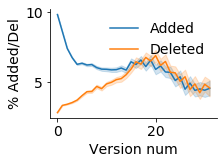

In [12]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(
    x='version_x', 
    y='perc', 
    data=(
        all_perc_df
          .set_index('version_x')[['perc_new_sents', 'perc_old_sents']]
          .unstack()
          .reset_index()
          .loc[lambda df: df['version_x'] < 32]
          .assign(perc=lambda df: df[0]*100)
    ), 
    hue='level_0',
    ax=ax
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version num')
plt.ylabel('% Added/Del')
plt.legend(['Added', 'Deleted'], frameon=False)
plt.savefig('figures/sent-changes__frac-total__slim.pdf', bbox_inches='tight')

In [51]:
t = (
        all_perc_df
          .set_index('version_x')[['perc_new_sents', 'perc_old_sents', 'perc_edited_sents']]
          .unstack()
          .reset_index()
          .loc[lambda df: df['version_x'] < 32]
          .assign(perc=lambda df: df[0]*100)
#     .sample(100000)
    )

In [55]:
t['perc'] = t['perc'].round().astype(int)
t2 = t.groupby(['level_0', 'version_x'])['perc'].mean().reset_index()
t3 = t2.pivot(index='version_x', columns='level_0', values='perc')

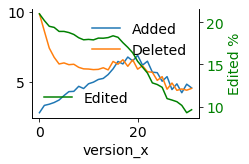

In [124]:
ax = t3[['perc_old_sents', 'perc_new_sents']].plot(figsize=(3, 2))
ax2 = ax.twinx()
ax2.set_ylabel('Edited %', color='g')  # we already handled the x-label with ax1
t3['perc_edited_sents'].plot(ax=ax2, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.legend(['Added', 'Deleted', 'Edited'], frameon=False)#, ncol=2)
ax2.legend(['Edited'], frameon=False, ncol=2)

[]

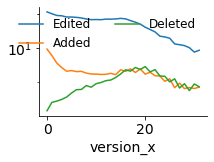

In [245]:
ax = t3.plot(figsize=(3, 2))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(['Edited', 'Added', 'Deleted'],
          frameon=False, ncol=2, fontsize=12)

# plt.yticks([0, 1, 10])
plt.semilogy(subsy=[0, 1, 2, 5, 10, 20])

In [13]:
label_map = {
    'perc_new_sents':'Added',
    'perc_old_sents': 'Deleted',
    'perc_edited_sents': 'Edited'
}

to_plot = (
        all_perc_df
          .set_index('version_x')[['perc_new_sents', 'perc_old_sents', 'perc_edited_sents']]
          .unstack()
          .reset_index()
          .loc[lambda df: df['version_x'] < 32]
          .assign(perc=lambda df: df[0]*100)
          .assign(level_0=lambda df: df['level_0'].map(label_map))
    )

In [14]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

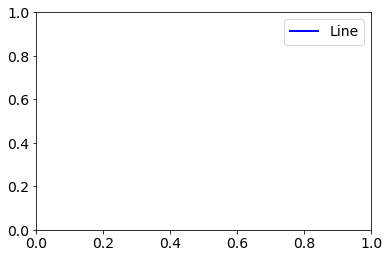

In [15]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
cmap = plt.cm.coolwarm



fig, ax = plt.subplots()
red_patch = mpatches.Patch(color='red', label='The red data', linewidth=0)
custom_lines = [Line2D([0], [0], color='b', lw=2, label='Line')]
ax.legend(handles=
custom_lines
)

plt.show()

In [16]:
'T'

'T'

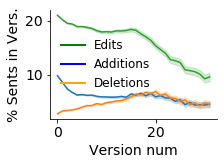

In [17]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(
    x='version_x', 
    y='perc', 
    data=to_plot, 
    hue='level_0',
    ax=ax
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version num')
plt.ylabel('% Sents in Vers.')
ax.legend(
    handles=[
        Line2D([0], [0], color='green', lw=2, label='Edits'),
        Line2D([0], [0], color='blue', lw=2, label='Additions'),
        Line2D([0], [0], color='orange', lw=2, label='Deletions')
#         mpatches.Patch(color='green', label='Edited'),
#         mpatches.Patch(color='blue', label='Added'),
#         mpatches.Patch(color='orange', label='Deleted'),
    ],
#     ['Edited', 'Added', 'Deleted'], 
    frameon=False,
    fontsize=12
)
plt.savefig('figures/sent-changes__frac-total-with-edits__slim.pdf', bbox_inches='tight')

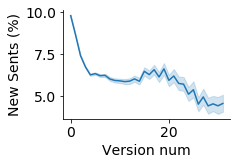

In [33]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(
    x='version_x', 
    y='perc_new_sents', 
    data=(all_perc_new_df
          .loc[lambda df: df['version_x'] < 32]
          .assign(perc_new_sents=lambda df: df['perc_new_sents']*100)
         ), 
    ax=ax
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version num')
plt.ylabel('New Sents (%)')
plt.savefig('figures/new-sents__frac-total__slim.pdf', bbox_inches='tight')

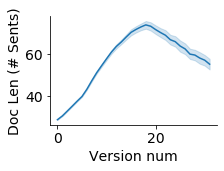

In [34]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(x='version', y='num_sents', data=all_num_sents_df.loc[lambda df: df['version'] < 32], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Version num')
plt.ylabel('Doc Len (# Sents)')
plt.savefig('figures/doc-len__slim.pdf', bbox_inches='tight')

In [174]:
all_new_df.head()

,sent_idx_y,addition
0,8.0,0
1,3.0,0
2,26.0,0
3,1.0,0
4,0.0,0


In [175]:
all_del_df.head()

,sent_idx_x,deletion
0,8.0,0
1,3.0,0
2,15.0,0
3,1.0,0
4,0.0,0


In [173]:
all_edited_df.head()

,sent_idx_x,edit
0,8.0,0.0
1,3.0,0.0
2,15.0,0.0
3,1.0,0.0
4,0.0,0.0


In [177]:
all_changes = pd.concat([
    all_new_df.rename(columns={'sent_idx_y': 'sent_idx'}).set_index('sent_idx').unstack(),
    all_del_df.rename(columns={'sent_idx_x': 'sent_idx'}).set_index('sent_idx').unstack(),
    all_edited_df.rename(columns={'sent_idx_x': 'sent_idx'}).set_index('sent_idx').unstack()
])

In [178]:
all_changes = all_changes.reset_index()

In [179]:
all_changes.head()

,level_0,sent_idx,0
0,addition,8.0,0.0
1,addition,3.0,0.0
2,addition,26.0,0.0
3,addition,1.0,0.0
4,addition,0.0,0.0


In [180]:
all_changes.shape 

(204500307, 3)

In [64]:
all_changes.shape 

(137078635, 3)

In [187]:
small_changes = all_changes.sample(10_000_000)
smaller_changes = all_changes.sample(1_000_000)

In [ ]:
f, ax= plt.subplots(1, 1, figsize=(6, 2))
ax = sns.lineplot(x='sent_idx', y=0, hue='level_0', data=small_changes, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Sentence Index')
plt.ylabel('frac. sents')
plt.legend(['added', 'deleted'], frameon=False)
plt.savefig('figures/change-by-position__with-edits.pdf', bbox_inches='tight')

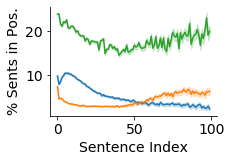

In [250]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(
    x='sent_idx', 
    y='perc',
    hue='level_0', 
    data=small_changes.assign(perc=lambda df: df[0]*100).sort_values('level_0'), 
    ax=ax
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Sentence Index')
plt.ylabel('% Sents in Pos.')
ax.legend().set_visible(False)
# plt.legend(['Edited', 'Added', 'Deleted'], frameon=False)
plt.savefig('figures/change-by-position__with-edits__slim.pdf', bbox_inches='tight')

In [248]:
smaller_changes

,level_0,sent_idx,0
40228645,addition,9.0,0.0
37944726,addition,18.0,1.0
1404706,addition,8.0,0.0
25211673,addition,9.0,0.0
40360459,addition,11.0,0.0
...,...,...,...
161555135,edit,43.0,0.0
142775126,edit,3.0,0.0
202800262,edit,16.0,0.0
187393743,edit,23.0,0.0


Text(0, 0.5, 'Likelihood of Addition')

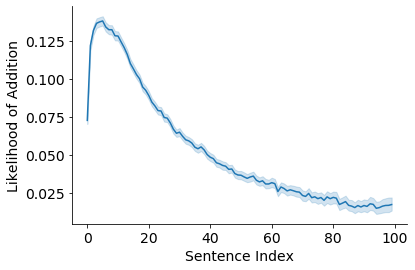

In [745]:
f, ax= plt.subplots(1, 1, figsize=(3, 2))
ax = sns.lineplot(x='sent_idx_y', y='addition', data=new_sent_slot, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Sentence Index')
plt.ylabel('Likelihood of Addition')

Text(0, 0.5, 'Likelihood of Deletion')

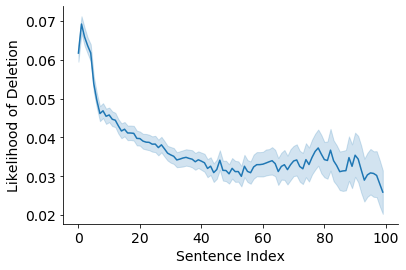

In [749]:
ax = sns.lineplot(x='sent_idx_x', y='deletion', data=del_sent_slot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Sentence Index')
plt.ylabel('Likelihood of Deletion')

# Try to come up with a good refactoring algorithm

In [6]:
# similar problem: 
# adapted from: https://github.com/akhiluanandh/SPOJ/blob/master/MSE06H.cpp
# binary index tree tutorial: https://www.youtube.com/watch?v=v_wj_mOAlig&t=648s

import numpy as np
from more_itertools import unique_everseen
import pandas as pd
from collections import defaultdict


def read(pos, tree):
    count = []
    while (pos > 0):
        count += tree[pos]
        pos -= (pos & -pos)
    return count


def update(pos, MAX, edge, tree):
    while (pos <= MAX):
        tree[pos].append(edge)
        pos += (pos & -pos)


def _find_crossings(n, m, e):
    """
    Method to find crossings on a bipartite graph

    n: num nodes on left
    m: num nodes on right
    e: edges -> tuples of (node_idx_left, node_idx_right)
    """
    tree = defaultdict(list)
    k = len(e)
    e = sorted(e)
    res = {}
    for i in range(k):
        r_m = read(m, tree)
        r_e = read(e[i][1], tree)
        c = set(r_m) - set(r_e)
        print('m: %s, read m: %s, e: %s, read e: %s, c: %s' % (m, str(r_m), str(e[i]), str(r_e), str(c)))
        res[e[i]] = c
        update(e[i][1], m, e[i], tree)
    ##
    return res, tree

In [7]:
n = 3
m = 3
k = 5
e = [
    (1, 2),
    (1, 3),
    (2, 2),
    (2, 3),
    (3, 1)
]

In [8]:
r, tree = _find_crossings(n, m, e)

m: 3, read m: [], e: (1, 2), read e: [], c: set()
m: 3, read m: [(1, 2)], e: (1, 3), read e: [(1, 2)], c: set()
m: 3, read m: [(1, 3), (1, 2)], e: (2, 2), read e: [(1, 2)], c: {(1, 3)}
m: 3, read m: [(1, 3), (1, 2), (2, 2)], e: (2, 3), read e: [(1, 3), (1, 2), (2, 2)], c: set()
m: 3, read m: [(1, 3), (2, 3), (1, 2), (2, 2)], e: (3, 1), read e: [], c: {(2, 3), (1, 2), (1, 3), (2, 2)}


In [9]:
for key, crossings in r.items():
    for c in crossings:
        if key not in r[c]:
            r[c].add(key)

for key in r:
    print(key, ' : ', r[key])

(1, 2)  :  {(3, 1)}
(1, 3)  :  {(3, 1), (2, 2)}
(2, 2)  :  {(3, 1), (1, 3)}
(2, 3)  :  {(3, 1)}
(3, 1)  :  {(2, 3), (1, 2), (1, 3), (2, 2)}


# Remove crossings

In [32]:
def remove_crossings(dict_r):
    maxCrossings = 0
    
    for key, crossings in dict_r.items():
        if len(crossings) > maxCrossings:
            maxCrossings = len(crossings)
            maxCrossings_key = key
    
    if len(dict_r[maxCrossings_key]) == 1:
        sub_value = list(dict_r[maxCrossings_key])[0][0] - list(dict_r[maxCrossings_key])[0][1]
        sub_key = maxCrossings_key[0] - maxCrossings_key[1]
        
        if abs(sub_key) == abs(sub_value):
            if sub_key < 0:
                maxCrossings_key = list(dict_r[maxCrossings_key])[0]
        elif abs(sub_key) < abs(sub_value):
            maxCrossings_key = list(dict_r[maxCrossings_key])[0]
            
        print('remove : ', maxCrossings_key)
        dict_r.pop(maxCrossings_key)
    else:
        print('remove : ', maxCrossings_key)
        dict_r.pop(maxCrossings_key)

    for key, crossings in dict_r.items():
        if maxCrossings_key in crossings:
            dict_r[key].remove(maxCrossings_key)

    return dict_r

In [11]:
import copy
r_copy = copy.deepcopy(r)

while any(r_copy.values()) == True:
    remove_crossings(r_copy)
    
    for key in r_copy:
        print(key, ' : ', r_copy[key])
        
    print ()

remove :  (3, 1)
(1, 2)  :  set()
(1, 3)  :  {(2, 2)}
(2, 2)  :  {(1, 3)}
(2, 3)  :  set()

remove :  (1, 3)
(1, 2)  :  set()
(2, 2)  :  set()
(2, 3)  :  set()



# Real data

In [12]:
pd.read_sql('''
    SELECT ENTRY_ID, COUNT() FROM MATCHED_SENTENCES
    WHERE SENT_IDX_X <> SENT_IDX_Y
    GROUP BY ENTRY_ID
    LIMIT 10
''', con=con)

,entry_id,COUNT()
0,728193,5
1,728194,3
2,728213,38
3,728214,25
4,728219,8
5,728225,3
6,728241,22
7,728243,54
8,728347,1
9,728359,91


In [38]:
sample_article = pd.read_sql('''
    SELECT * FROM MATCHED_SENTENCES
    WHERE (ENTRY_ID = 728193) AND (SENT_IDX_X <> SENT_IDX_Y)
''', con=con)

sample_article

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance_x,avg_sentence_distance_y
0,728193,0,1,7.0,5.0,0.406263,0.406352
1,728193,0,1,14.0,16.0,0.279757,0.279757
2,728193,0,1,8.0,9.0,0.322441,0.322441
3,728193,0,1,6.0,8.0,0.331385,0.334442
4,728193,0,1,5.0,6.0,0.361877,0.361877


In [45]:
pd.read_sql('''
    SELECT * FROM SPLIT_SENTENCES
    WHERE 
        (ENTRY_ID = 728193) AND
        (SENT_IDX = 7) AND
        (VERSION = 0)
    UNION
    SELECT * FROM SPLIT_SENTENCES
    WHERE 
        (ENTRY_ID = 728193) AND
        (SENT_IDX = 5) AND
        (VERSION = 1)    
''', con=con)

,entry_id,version,sent_idx,sentence
0,728193,0,7,"Isra al-Modallah, the Hamas spokeswoman, said ..."
1,728193,1,5,"Isra al-Modallah, the spokeswoman, said a 12-y..."


In [41]:
n = 14
m = 16
k = 5
e = [
    (7, 5),
    (14, 16),
    (8, 9),
    (6, 8),
    (5, 6)
]

In [42]:
r, tree = _find_crossings(n, m, e)

m: 16, read m: [], e: (5, 6), read e: [], c: set()
m: 16, read m: [(5, 6)], e: (6, 8), read e: [(5, 6)], c: set()
m: 16, read m: [(5, 6), (6, 8)], e: (7, 5), read e: [], c: {(6, 8), (5, 6)}
m: 16, read m: [(5, 6), (6, 8), (7, 5)], e: (8, 9), read e: [(5, 6), (6, 8), (7, 5)], c: set()
m: 16, read m: [(5, 6), (6, 8), (7, 5), (8, 9)], e: (14, 16), read e: [(5, 6), (6, 8), (7, 5), (8, 9)], c: set()


In [43]:
for key, crossings in r.items():
    for c in crossings:
        if key not in r[c]:
            r[c].add(key)

for key in r:
    print(key, ' : ', r[key])

(5, 6)  :  {(7, 5)}
(6, 8)  :  {(7, 5)}
(7, 5)  :  {(6, 8), (5, 6)}
(8, 9)  :  set()
(14, 16)  :  set()


In [44]:
import copy
r_copy = copy.deepcopy(r)

while any(r_copy.values()) == True:
    remove_crossings(r_copy)
    
    for key in r_copy:
        print(key, ' : ', r_copy[key])
        
    print ()

remove :  (7, 5)
(5, 6)  :  set()
(6, 8)  :  set()
(8, 9)  :  set()
(14, 16)  :  set()



# Previous

In [17]:
def find_crossings(sents_old, sents_new):
    """
    Method to find refactorings (i.e. whether pairs of sentences cross each other in a bipartite graph)

    params:
    * sents_old: list (or pd.Series) of sentences from the old version
    * sents_new: list (or pd.Series) of sentences from the new version

    returns:
    * num_crossings: the number of sentences that have been refactored,
        i.e. the number of edges in a bipartite graph of sentences that cross each other.
    """
    # drop additions/deletions (these don't affect refactorings)
    sents_old = list(filter(pd.notnull, sents_old))
    sents_new = list(filter(pd.notnull, sents_new))
    sents_old = list(map(int, sents_old))
    sents_new = list(map(int, sents_new))

    # make it not zero-indexed, for bitwise addition
    correct_zero = lambda x: x
    if min(sents_old) == 0:
        correct_zero = lambda x: x + 1

    # map missing indices (the result of dropping additions/deletions) to a compressed set.
    sents_old_map = {v: correct_zero(k) for k, v in enumerate(unique_everseen(sents_old))}
    sents_new_map = {v: correct_zero(k) for k, v in enumerate(unique_everseen(sents_new))}

    # prepare input to function
    n = len(sents_old_map)
    m = len(sents_new_map)
    sents_old = list(map(sents_old_map.get, sents_old))
    sents_new = list(map(sents_new_map.get, sents_new))
    e = list(zip(sents_old, sents_new))

    # calculate and return
    return _find_crossings(n, m, e)

In [18]:
def find_refactor(article_df):
    num_crossings = find_crossings(article_df['sent_idx_x'], article_df['sent_idx_y'])
    return num_crossings > 0

In [19]:
sample_articles = pd.read_sql('''
    SELECT * FROM MATCHED_SENTENCES
    WHERE ENTRY_ID = 728192
''', con=con)

In [20]:
refactors = (sample_articles
 .groupby(['entry_id', 'version_x', 'version_y'])
 .apply(find_refactor)
 .loc[lambda s: s]
)

NameError: name 'unique_everseen' is not defined

In [68]:
refactors_test = (sample_articles
 .groupby(['entry_id', 'version_x', 'version_y'])
 .apply(find_refactor_test)
 .loc[lambda s: s]
)
refactors_test

0     44.0
1     20.0
2     10.0
3     12.0
4     39.0
5     22.0
6     38.0
7     23.0
8      5.0
9     19.0
10    15.0
11     7.0
12    37.0
13    25.0
14    32.0
15     3.0
16    43.0
17    42.0
18    35.0
19    34.0
20    26.0
21    31.0
22     6.0
23    29.0
24    45.0
25    46.0
26    27.0
27    17.0
28    30.0
29    11.0
30    36.0
31    13.0
32    24.0
33     4.0
34     2.0
35    14.0
36    18.0
37    21.0
38     1.0
39    33.0
40    16.0
41     8.0
42    40.0
43     0.0
44    41.0
45    28.0
46     9.0
Name: sent_idx_x, dtype: float64
0     44.0
1     20.0
2     10.0
3     12.0
4     39.0
5     22.0
6     38.0
7     23.0
8      5.0
9     19.0
10    15.0
11     7.0
12    37.0
13    25.0
14    32.0
15     3.0
16    43.0
17    42.0
18    35.0
19    34.0
20    26.0
21    31.0
22     6.0
23    29.0
24    45.0
25    46.0
26    27.0
27    17.0
28    30.0
29    11.0
30    36.0
31    13.0
32    24.0
33     4.0
34     2.0
35    14.0
36    18.0
37    21.0
38     1.0
39    33.0
40    16.0

entry_id  version_x  version_y
728192    0          1            True
dtype: bool

In [67]:
def find_refactor_test(article_df):
    num_crossings = 1
    print (article_df['sent_idx_x'])
    print (article_df['sent_idx_y'])
    #= find_crossings_test(article_df['sent_idx_x'], article_df['sent_idx_y'])
    return num_crossings > 0

In [46]:
def find_crossings_test(sents_old, sents_new):
    """
    Method to find refactorings (i.e. whether pairs of sentences cross each other in a bipartite graph)

    params:
    * sents_old: list (or pd.Series) of sentences from the old version
    * sents_new: list (or pd.Series) of sentences from the new version

    returns:
    * num_crossings: the number of sentences that have been refactored,
        i.e. the number of edges in a bipartite graph of sentences that cross each other.
    """
    # drop additions/deletions (these don't affect refactorings)
    sents_old = list(filter(pd.notnull, sents_old))
    sents_new = list(filter(pd.notnull, sents_new))
    sents_old = list(map(int, sents_old))
    sents_new = list(map(int, sents_new))

    # make it not zero-indexed, for bitwise addition
    correct_zero = lambda x: x
    if min(sents_old) == 0:
        correct_zero = lambda x: x + 1

#     # map missing indices (the result of dropping additions/deletions) to a compressed set.
    sents_old_map = {v: correct_zero(k) for k, v in enumerate(unique_everseen(sents_old))}
    sents_new_map = {v: correct_zero(k) for k, v in enumerate(unique_everseen(sents_new))}

    # prepare input to function
    n = len(sents_old_map)
    m = len(sents_new_map)
    sents_old = list(map(sents_old_map.get, sents_old))
    sents_new = list(map(sents_new_map.get, sents_new))
    e = list(zip(sents_old, sents_new))

    # calculate and return
    #return _find_crossings(n, m, e)
    return n, m, e

In [16]:
refactors.head()

NameError: name 'refactors' is not defined

In [19]:
a_id, v_x, v_y = refactors.index[0]

NameError: name 'refactors' is not defined

In [17]:
s_x = pd.read_sql('''
    SELECT * FROM split_sentences 
    WHERE 
    entry_id = %s AND version = %s
''' % (a_id, v_x), con=con)

NameError: name 'a_id' is not defined

In [21]:
s_y = pd.read_sql('''
    SELECT * FROM split_sentences 
    WHERE 
    entry_id = %s AND version = %s
''' % (a_id, v_y), con=con)

NameError: name 'a_id' is not defined

In [355]:
vars_o, vars_n = unp.get_list_diff(s_x['sentence'].tolist(), s_y['sentence'].tolist())

In [436]:
output_html = unp.html_compare_articles(vars_old=vars_o[:4], vars_new=vars_n[:4])

In [437]:
display(HTML(output_html))

Old Version,New Version
"LAS VEGAS Donald Trump goes into his third and final presidential debate on the defensive, with Hillary Clinton threatening to poach a string of once loyally Republican states from a man who says he hates losers.","LAS VEGAS Donald Trump goes into his third and final presidential debate on the defensive, with Hillary Clinton threatening to poach a string of once loyally Republican states from a man who says he hates losers."
"Trump is in danger of being one of his party’s biggest losers — and, as President Obama pointed out on Tuesday, a whiny one at that.","Trump is in danger of being one of his party’s biggest losers — and, as President Obama pointed out on Tuesday, a whiny one at that."
"The states on Clinton’s new target list include Arizona and, of all places, Texas.","The states on Clinton’s new target list include Arizona and, of all places, Texas."
"In Nevada, the polling is mixed, though Clinton seems to have gained ground.","In Nevada, the polling is mixed, though Clinton seems to have gained ground."


# Try to write some HTML that will visualize refactors well

In [22]:
unp.html_compare_sentences_new(
    comp_sents, 
    head_comp_df=comp_heads,
    sort_by='old',
    include_headline=True, 
)


AttributeError: module 'util_newssniffer_parsing' has no attribute 'html_compare_sentences_new'

In [23]:
(sample_articles
 .loc[lambda df: df['entry_id'] == a_id]
 .loc[lambda df: df['version_x'] == v_x]
 .loc[lambda df: df['version_y'] == v_y]
).head()

NameError: name 'sample_articles' is not defined

In [339]:
t = (sample_articles
 .loc[lambda df: df['entry_id'] == a_id]
 .loc[lambda df: df['version_x'] == v_x]
 .loc[lambda df: df['version_y'] == v_y]
)

In [431]:
svg = """
<svg width="300" height="100">
    <text x='100' y='0' font-size='18px' text-anchor='end'>
      <tspan x='100' dy='1em'>foo1</tspan>
      <tspan x='100' dy='1em'>foo2</tspan>
      <tspan x='100' dy='1em'>foo3</tspan>
    </text>
    <text x='200' y='0' font-size='18px'>
      <tspan x='200' dy='1em'>foo4</tspan>
      <tspan x='200' dy='1em'>foo5</tspan>
      <tspan x='200' dy='1em'>foo6</tspan>
    </text>
    <line x1='100' y1='0.8em' x2='200' y2='2.8em' style="stroke:#999999"/>
    <line x1='100' y1='1.8em' x2='200' y2='1.8em' style="stroke:#999999"/>
    <line x1='100' y1='1.8em' x2='200' y2='0.8em' style="stroke:#ff0000"/>
    <line x1='100' y1='0.8em' x2='200' y2='1.8em' style="stroke:#ff0000"/>
    <line x1='100' y1='2.8em' x2='200' y2='2.8em' style="stroke:#00ff00"/>
</svg>""".replace('\'', '"')

In [432]:
from IPython.display import SVG, display

In [433]:
svg

'\n<svg width="300" height="100">\n    <text x="100" y="0" font-size="18px" text-anchor="end">\n      <tspan x="100" dy="1em">foo1</tspan>\n      <tspan x="100" dy="1em">foo2</tspan>\n      <tspan x="100" dy="1em">foo3</tspan>\n    </text>\n    <text x="200" y="0" font-size="18px">\n      <tspan x="200" dy="1em">foo4</tspan>\n      <tspan x="200" dy="1em">foo5</tspan>\n      <tspan x="200" dy="1em">foo6</tspan>\n    </text>\n    <line x1="100" y1="0.8em" x2="200" y2="2.8em" style="stroke:#999999"/>\n    <line x1="100" y1="1.8em" x2="200" y2="1.8em" style="stroke:#999999"/>\n    <line x1="100" y1="1.8em" x2="200" y2="0.8em" style="stroke:#ff0000"/>\n    <line x1="100" y1="0.8em" x2="200" y2="1.8em" style="stroke:#ff0000"/>\n    <line x1="100" y1="2.8em" x2="200" y2="2.8em" style="stroke:#00ff00"/>\n</svg>'

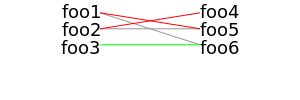

In [548]:
SVG(svg)

In [484]:
t_table = pd.DataFrame({
    'a': ['The the the the the the the the','The the the the the the the the','The the the the the the the the','The the the the the the the the',],
    'b': ['The the the the the the the the','The the the the the the the the','The the the the the the the the','The the the the the the the the',]
})
t_table[''] = ''
t_table = t_table[['a', '', 'b']]

In [536]:
t_table

,a,,b
0,The the the the the the the the,,The the the the the the the the
1,The the the the the the the the,,The the the the the the the the
2,The the the the the the the the,,The the the the the the the the
3,The the the the the the the the,,The the the the the the the the


In [542]:
t_table_html = """
<table style="width: 100%">
  <colgroup>
     <col span="1" style="width: 10%;">
     <col span="1" style="width: 10%;">
     <col span="1" style="width: 45%;">
  </colgroup>
  <tbody>
    <tr>
      <td>The the the the the the the the</td>
      <td></td>
      <td>The the the the the the the the</td>
    </tr>
    <tr>
      <td>The the the the the the the the</td>
      <td></td>
      <td>The the the the the the the the</td>
    </tr>
    <tr>
      <td>The the the the the the the the</td>
      <td></td>
      <td>The the the the the the the the</td>
    </tr>
    <tr>
      <td>The the the the the the the the</td>
      <td></td>
      <td>The the the the the the the the</td>
    </tr>
  </tbody>
</table>
"""

In [543]:
svg_tab = """<svg xmlns="http://www.w3.org/2000/svg">
  <foreignObject x="10" y="10" width="800" height="1500">
    <body xmlns="http://www.w3.org/1999/xhtml">
      %s
    </body>
  </foreignObject>
  <line x1='100' y1='0.8em' x2='200' y2='2.8em' style="stroke:#999999"/>
  <line x1='100' y1='1.8em' x2='200' y2='1.8em' style="stroke:#999999"/>
  <line x1='100' y1='1.8em' x2='200' y2='0.8em' style="stroke:#ff0000"/>
  <line x1='100' y1='0.8em' x2='200' y2='1.8em' style="stroke:#ff0000"/>
  <line x1='100' y1='2.8em' x2='200' y2='2.8em' style="stroke:#00ff00"/>
</svg>""" % t_table_html
svg_tab = t_table_html + """
<svg style="
    position: absolute;
    width: 100%;
    height: 100%;
    top: 0;
    left: 0;">
  <line x1='100' y1='0.8em' x2='200' y2='2.8em' style="stroke:#999999"/>
  <line x1='100' y1='1.8em' x2='200' y2='1.8em' style="stroke:#999999"/>
  <line x1='100' y1='1.8em' x2='200' y2='0.8em' style="stroke:#ff0000"/>
  <line x1='100' y1='0.8em' x2='200' y2='1.8em' style="stroke:#ff0000"/>
  <line x1='100' y1='2.8em' x2='200' y2='2.8em' style="stroke:#00ff00"/>
</svg>"""

In [544]:
display(HTML(svg_tab))

The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the


In [545]:
display(HTML(t_table_html))

The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the
The the the the the the the the,,The the the the the the the the


In [516]:
test = """
<svg style="
    position: absolute;
    width: 100%;
    height: 100%;
    top: 0;
    left: 0;">
  <line x1="0" y1="0" x2="200" y2="200" style="stroke:rgb(255,0,0);stroke-width:2"></line>
</svg>
<table>
  <thead>
    <tr>
      <th>1 </th>
      <th>2 </th>
      <th>3 </th>
    </tr>
  </thead>
  <tbody>
    <tr style="height: 30px;">
      <td style="position: absolute; left: 100px;">
        <div>Connection 1 </div>
      </td>
    </tr>
    <tr style="height: 30px;">
      <td>
        <div style="position: absolute; left: 200px;">Connection 2 </div>
      </td>
    </tr>
    <tr style="height: 30px;">
      <td>
        <div style="position: absolute; left: 400px;">Connection 3 </div>
      </td>
    </tr>
    <tbody>
</table>
"""

In [517]:
display(HTML(test))